In [1]:
import pandas as pd
import nltk
import re

import glob
import io
import numpy as np

import seaborn as sns
from decimal import Decimal
import locale
from datetime import datetime
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import gensim
from gensim.summarization import summarizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

## Job Titles list

In [39]:
with open('CityofLA/Job Bulletins/ADVANCE PRACTICE PROVIDER CORRECTIONAL CARE 2325 020808 REV 111214.txt', encoding = 'utf-8') as f:
    print(f.readlines())

['ADVANCE PRACTICE PROVIDER CORRECTIONAL CARE\n', '                                           \n', '\tClass Code:       2325\n', 'Open Date:  02-08-08\n', 'REVISED:    11-12-14\n', '\n', 'ANNUAL SALARY\n', '\n', '$78,487 to $97,530 and $84,459 to $104,922\n', '\n', 'A 5.5% bonus may be paid upon proof of certification by a recognized national professional organization in a nurse practitioner specialty that is relevant and applicable to the duties performed.  Some positions require night work, for which a 5.5% bonus is paid.\n', '\n', 'NOTE:\n', '\n', 'The current salary range is subject to change. You may confirm the starting salary with the hiring department before accepting a job offer.\n', '\n', 'DUTIES\n', '\n', "An Advance Practice Provider Correctional Care is responsible for obtaining medical histories, performing physical examinations, ordering and interpreting diagnostic tests, assessing medical conditions, providing medical care and treatment, and performing related duties as

In [4]:
with open('CityofLA/Additional data/kaggle_data_dictionary.csv', encoding = 'utf-8') as f:
    print(f.readlines())

['Field Name,Annotation Letter,Description,Data Type,Allowable Values,Accepts Null Values?,Additional Notes\n', 'FILE_NAME,,The file name of the job bulletin from which each record came,String,,No,\n', 'JOB_CLASS_TITLE,A,"The title of the particular class (e.g., Systems Analyst, Carpenter)",String,Any job title matching in in supplied job bulletins,No,\n', 'JOB_CLASS_NO,B,The 4-digit code that corresponds to the job class.,String,Any four character numeric string matching one in supplied job bulletins,No,"Some classes have three non-zero digits — e.g., 0162. These will take the form 0###"\n', 'REQUIREMENT_SET_ID,D1,"A main requirement that has to be filled. These are identified with numbers in the job bulletin. Relationships between requirement sets are specified by an ""AND|OR"" conjunction (data element E1 on the data annotation chart)",Integer,Any positive integer,No,\n', 'REQUIREMENT_SUBSET_ID,D2,"A secondary requirement that has to be filled, nested under a REQUIREMENT_SET_ID. The

In [31]:
job_titles = pd.read_csv('CityofLA/Additional data/job_titles.csv', header = None)

In [32]:
job_titles

,0
0,311 DIRECTOR
1,ACCOUNTANT
2,ACCOUNTING CLERK
3,ACCOUNTING RECORDS SUPERVISOR
4,ADMINISTRATIVE ANALYST
5,ADMINISTRATIVE CLERK
6,ADMINISTRATIVE HEARING EXAMINER
7,ADVANCE PRACTICE PROVIDER CORRECTIONAL CARE
8,AIR CONDITIONING MECHANIC
9,AIR CONDITIONING MECHANIC SUPERVISOR


In [35]:
sample_job_export = pd.read_csv('CityofLA/Additional data/sample job class export template.csv')

In [36]:
sample_job_export

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,JOB_DUTIES,EDUCATION_YEARS,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EXP_JOB_CLASS_TITLE,EXP_JOB_CLASS_ALT_RESP,EXP_JOB_CLASS_FUNCTION,COURSE_COUNT,COURSE_LENGTH,COURSE_SUBJECT,MISC_COURSE_DETAILS,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,ADDTL_LIC,EXAM_TYPE,ENTRY_SALARY_GEN,ENTRY_SALARY_DWP,OPEN_DATE
0,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,1,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,COMPUTER SCIENCE|INFORMATION SYSTEMS|GEOGRAPHI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
1,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,FULL-TIME,MANAGEMENT ASSISTANT,NaN,"the development, analysis, implementation or m...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
2,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,B,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,FULL-TIME,MANAGEMENT ASSISTANT,NaN,"performing cost benefit, feasibility and requi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
3,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,C,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,FULL-TIME,MANAGEMENT ASSISTANT,NaN,performing system implementation and support a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
4,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,3,A,"A Systems Analyst analyzes procedures, methods...",NaN,NaN,NaN,2.0,FULL-TIME,SYSTEMS AIDE,NaN,NaN,4.0,"3M, 4Q",INFORMATION SYSTEMS|SYSTEMS ANALYSIS|closely r...,At least three of the courses must be from the...,M,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17


## Data Dictionary

In [59]:
kaggle_data_dictionary = pd.read_csv('CityofLA/Additional data/kaggle_data_dictionary.csv')

In [63]:
kaggle_data_dictionary['Additional Notes'][21]

'Code explanation:\n\nOPEN: Exam open to anyone (pending other requirements)\nINT_DEPT_PROM: Interdepartmental Promotional\nDEPT_PROM: Departmental Promotional\nOPEN_INT_PROM: Open or Competitive Interdepartmental Promotional'

In [6]:
kaggle_data_dictionary

,Field Name,Annotation Letter,Description,Data Type,Allowable Values,Accepts Null Values?,Additional Notes
0,FILE_NAME,NaN,The file name of the job bulletin from which e...,String,NaN,No,NaN
1,JOB_CLASS_TITLE,A,"The title of the particular class (e.g., Syste...",String,Any job title matching in in supplied job bull...,No,NaN
2,JOB_CLASS_NO,B,The 4-digit code that corresponds to the job c...,String,Any four character numeric string matching one...,No,Some classes have three non-zero digits — e.g....
3,REQUIREMENT_SET_ID,D1,A main requirement that has to be filled. Thes...,Integer,Any positive integer,No,NaN
4,REQUIREMENT_SUBSET_ID,D2,"A secondary requirement that has to be filled,...",String,Any letter or combination of letters.,No,"A-Z represents 1-26. In the case of 27th, 28th..."
5,JOB_DUTIES,C,A summary of what someone does in the particul...,String,NaN,No,NaN
6,EDUCATION_YEARS,F,Years required in a particular education program,Float,Any positive float representing years or a fra...,Yes,Any job description that mentions months shoul...
7,SCHOOL_TYPE,G,School Type: School type required (e.g. colleg...,String,"COLLEGE OR UNIVERSITY, HIGH SCHOOL, APPRENTICE...",Yes,Allowable value list is most likely incomplete...
8,EDUCATION_MAJOR,H,Major or concentration required,String,NaN,Yes,A list of many sufficient majors should appear...
9,EXPERIENCE_LENGTH,I,Years required in a particular job class or ex...,Float,NaN,Yes,Some classes may specify months rather than ye...


In [7]:
kaggle_data_dictionary.iloc[3]['Description']

'A main requirement that has to be filled. These are identified with numbers in the job bulletin. Relationships between requirement sets are specified by an "AND|OR" conjunction (data element E1 on the data annotation chart)'

## Sample 

In [9]:
sample = pd.read_csv('CityofLA/Additional data/sample job class export template.csv')

In [10]:
sample.head()

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,JOB_DUTIES,EDUCATION_YEARS,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERIENCE_LENGTH,...,COURSE_LENGTH,COURSE_SUBJECT,MISC_COURSE_DETAILS,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,ADDTL_LIC,EXAM_TYPE,ENTRY_SALARY_GEN,ENTRY_SALARY_DWP,OPEN_DATE
0,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,1,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,COMPUTER SCIENCE|INFORMATION SYSTEMS|GEOGRAPHI...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
1,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
2,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,B,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
3,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,C,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
4,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,3,A,"A Systems Analyst analyzes procedures, methods...",NaN,NaN,NaN,2.0,...,"3M, 4Q",INFORMATION SYSTEMS|SYSTEMS ANALYSIS|closely r...,At least three of the courses must be from the...,M,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17


In [2]:
code = r'Class\s{1,2}Code:\s*(\d*)'
open_d = r'Open Date:\s*(\d\d-\d\d-\d\d)'
sal = r'(\$(\d+,\d+))((\s(to|and|-)\s)(\$\d+,\d+))?' # Taken from kaggle kernel
sal_dwp = r'Power\sis\s((\$(\d+,\d+))((\s(to|and|-)\s)(\$\d+,\d+))?)'
dut = r'DUTIES\W+(.*\n)' # Duties
req = r'REQUIREMENT(S)?(/MINIMUM\sQUALIFICATION)?\W+(.*\n)' #Requirements
end_d = r'(MONDAY|TUESDAY|WEDNESDAY|THURSDAY|FRIDAY|SATURDAY|SUNDAY)\W+(JANUARY|FEBRUARY|MARCH|APRIL|MAY|JUNE|JULY|AUGUST|SEPTEMBER|OCTOBER|NOVEMBER|DECEMBER)(.*\d)'
exp_len = r'(one|two|three|four|five|six|seven|eight|nine)\s(?=(year|years|month|months)\sof\s(?=(full-time|part-time)))' 
sch_typ = r'(college|university|high school|apprentice)' # School Type
edu_y = r'(\b\w+(-year))(?=\D+(college|university))' #Education Year
edu_major = r'(college or university|college|university|apprentice)\D+(in|as a)\s(\D+);' # Education Major
course_l = r'(\d+\ssemester.+quarter(\sunits)?)'
#open_d = r'Open Date: (.*)\n' 

In [3]:
def doextraction(glob_text):
    col = ['FILE_NAME', 'JOB_CLASS_TITLE', 'JOB_CLASS_NO', 'REQUIREMENT_SET_ID', 'REQUIREMENT_SUBSET_ID', 'JOB_DUTIES',\
           'EDUCATION_YEARS', 'SCHOOL_TYPE', 'EDUCATION_MAJOR', 'EXPERIENCE_LENGTH', 'FULL_TIME_PART_TIME', \
           'EXP_JOB_CLASS_TITLE', 'EXP_JOB_CLASS_ALT_RESP', 'EXP_JOB_CLASS_FUNCTION', 'COURSE_COUNT', 'COURSE_LENGTH',\
           'COURSE_SUBJECT', 'MISC_COURSE_DETAILS', 'DRIVERS_LICENSE_REQ', 'DRIV_LIC_TYPE', 'ADDTL_LIC', 'EXAM_TYPE', \
           'SALARY_START', 'SALARY_END', 'ENTRY_SALARY_DWP', 'REQUIREMENTS', 'APPLICATION_DEADLINE', 'OPEN_DATE']
    df = pd.DataFrame(columns = col) 
    """Get all the files from the given glob and pass them to the extractor."""
    for thefile in glob.glob(glob_text)[:200]:
        with io.open(thefile, 'r', encoding='utf-8') as fyl:
            text = fyl.read()
            df = get_features(text, thefile, df)
            
    return df

In [4]:
def get_headings(text): # Returns all the headings in the text file as a list 
    headings_list = []
    for line in text.split('\n'):
        if line.isupper():
            headings_list.append(line.strip())
    
    return headings_list

In [5]:
def get_job_class(text): 
    # This function returns the title and the class code of the job. 
    job_title = text.strip().splitlines()[0].strip()
    class_code = re.findall(code, text)[0]
    
    return job_title, class_code 

In [6]:
def get_open_date(text):
    try:
        open_date = re.findall(open_d, text)[0]
    except:
        open_date = np.NaN
        
    return open_date

In [7]:
def get_salary(text):
    salary_range = re.search(sal, text)
    
    try:
        salary_start = salary_range.group(1)
    except:
        salary_start = np.NaN
        
    try:
        salary_end = salary_range.group(6)
    except:
        salary_end = np.NaN
        
    salary_dwp = re.search(sal_dwp, text).group(1) if re.search(sal_dwp, text) is not None else np.NaN
    
    return salary_start, salary_end, salary_dwp

In [8]:
def get_requirement(headings, text):
    x = headings.index([elm for elm in headings if elm.startswith('REQUIREMENT')][0])
    m = re.search(headings[x], text).end()
    n = re.search(headings[x+1], text).start()
    requirement = text[m:n].strip()
    
    return requirement

In [9]:
def get_duties(headings, text):
    try:
        x = headings.index([elm for elm in headings if elm.startswith('DUT')][0])
        m = re.search(headings[x], text).end()
        n = re.search(headings[x+1], text).start()
        duties = text[m:n].strip()
    except:
        duties = np.NaN
        
    return duties

In [10]:
def get_req_id(requirement):
    req_id = re.search('(\d)\.', requirement.strip()[:2]).group(1) if re.search('(\d\.)', requirement.strip()[:2]) is \
            not None else np.NaN
    req_sub_id = re.search('\n(a)\.', requirement).group(1) if re.search('\n(a)\.', requirement) is not None \
            else np.NaN
    
    return req_id, req_sub_id

In [11]:
def get_exp_job(requirement):
    exp_id = re.findall(r'(?<=Los Angeles as a )(\w+\s\w+)', requirement)
    if len(exp_id) == 1:
        k1 = exp_id[0]
        k1b = np.NaN
    elif len(exp_id) > 1:
        k1 = exp_id[0]
        k1b = exp_id[1]
    else:
        k1 = k1b = np.NaN
    
    k2 = re.search('(?<=experience)(.+)(;|\.|or)', requirement).group(1).strip() if re.search('(?<=experience)(.+)(;|\.|or)', requirement)\
            is not None else np.NaN
    
    return k1, k1b, k2

In [97]:
def get_exam_type(headings):
    heads_text = ' '.join(headings)
    
    'Code explanation:\n\nOPEN: Exam open to anyone (pending other requirements)\nINT_DEPT_PROM: Interdepartmental Promotional\nDEPT_PROM: Departmental Promotional\nOPEN_INT_PROM: Open or Competitive Interdepartmental Promotional'

    if re.search('\sINTERDEPART\w+ PROMOT', heads_text) and re.search('\sOPEN COMPETIT', heads_text):
        e_type ='OPEN_INT_PROM'
    elif re.search('\sINTERDEPART\w+ PROMOT', heads_text):
        e_type = 'INT_DEPT_PROM'
    elif re.search('\sDEPARTMENT\w+ PROMOT', heads_text):
        e_type = 'T_PROM'
    else:
        e_type = 'OPEN'
        
    return e_type

In [100]:
def get_features(text, filename, df):
    filename = filename.replace('CityofLA/Job Bulletins\\', '')
    headings = get_headings(text)
    
    job_title, class_code = get_job_class(text)
    
    open_date = get_open_date(text)
    
    salary_start, salary_end, salary_dwp = get_salary(text)
    
    requirement = get_requirement(headings, text)
    
    req_id, req_sub_id = get_req_id(requirement)
    
    duties = get_duties(headings, text)
    
    # e1 is the conjunction used in the requirements
    e1 = requirement.splitlines()[0][-3:].strip() if len(requirement.splitlines()) >1 else np.NaN
    if e1 != 'and' and e1 != 'or':
        e1 = np.NaN
        
    k1, k1b, k2 =  get_exp_job(requirement)   
    
    # p1 and p2 are 'DRIVERS_LICENSE_REQ' and 'DRIV_LIC_TYPE'
    if re.search('(positions may require a valid California driver\'s license)', text, re.I) is not None:
        p1 = 'P'
        
    elif re.search('(driver\'s license is required)', text, re.I) is not None:
        p1 = 'R' 
        
    else:
        p1 = np.NaN
    
    p2 = re.search("((?<=Class)\s\w\s)(?=\D+driver's)", text, re.I).group(0).strip() if \
            re.search("((?<=Class)\s\w\s)(?=\D+driver's)", text, re.I) is not None else np.NaN
    
    try:
        x = re.findall(end_d, text)[0]
        deadline = ''.join(x).strip()
    except:
        deadline = np.NaN
     
    exam_type = get_exam_type(headings)
    
    df = df.append({'FILE_NAME': filename, 'JOB_CLASS_TITLE': job_title, 'JOB_CLASS_NO': class_code,\
                   'REQUIREMENT_SET_ID': req_id, 'REQUIREMENT_SUBSET_ID': req_sub_id, 'JOB_DUTIES': duties,\
                   'EXP_JOB_CLASS_TITLE': k1, 'EXP_JOB_CLASS_ALT_RESP': k1b, 'EXP_JOB_CLASS_FUNCTION': k2, \
                    'DRIVERS_LICENSE_REQ': p1, 'DRIV_LIC_TYPE': p2, 'EXAM_TYPE': exam_type, 'SALARY_START': salary_start, 'SALARY_END': salary_end, \
                    'ENTRY_SALARY_DWP': salary_dwp, 'REQUIREMENTS': requirement, 'APPLICATION_DEADLINE': deadline, \
                    'OPEN_DATE': open_date}, ignore_index = True)
    
    # Append the features extracted from each text file.
    return df

In [101]:
data_df = doextraction('CityofLA/Job Bulletins/*.txt')

In [146]:
def get_extra_features(data_df):
    data_df['EXPERIENCE_LENGTH'] = data_df.REQUIREMENTS.apply(lambda x: re.search(exp_len,x, re.IGNORECASE).group(1)+ ' ' + re.search(exp_len,x, re.IGNORECASE).group(2) \
                                                              if re.search(exp_len,x, re.IGNORECASE) is not None else np.NaN)
    data_df['FULL_TIME_PART_TIME'] = data_df.REQUIREMENTS.apply(lambda x: re.search(exp_len,x,re.I).group(3) if re.search(exp_len,x,re.I) is not None else np.NaN)
    data_df['SCHOOL_TYPE'] = data_df.REQUIREMENTS.apply(lambda x: re.search(sch_typ, x, re.I).group(1)\
                                                        if re.search(sch_typ, x, re.I) is not None else np.NaN)

    data_df['EDUCATION_YEARS'] = data_df.REQUIREMENTS.apply(lambda x: re.search(edu_y, x, re.I).group(1)\
                                                           if re.search(edu_y, x, re.I) is not None else np.NaN)


    data_df['EDUCATION_MAJOR'] = data_df.REQUIREMENTS.apply(lambda x: re.search(edu_major, x).group(3)\
                                                           if re.search(edu_major, x) is not None else np.NaN)
    
    
    data_df.COURSE_LENGTH = data_df.REQUIREMENTS.apply(lambda x: re.search(course_l, x, re.I).group(0) if re.search(course_l, x, re.I)\
                                                  is not None else np.NaN)
    return data_df

In [147]:
data_df = get_extra_features(data_df)

In [152]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
data_df

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,JOB_DUTIES,EDUCATION_YEARS,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EXP_JOB_CLASS_TITLE,EXP_JOB_CLASS_ALT_RESP,EXP_JOB_CLASS_FUNCTION,COURSE_COUNT,COURSE_LENGTH,COURSE_SUBJECT,MISC_COURSE_DETAILS,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,ADDTL_LIC,EXAM_TYPE,SALARY_START,SALARY_END,ENTRY_SALARY_DWP,REQUIREMENTS,APPLICATION_DEADLINE,OPEN_DATE,Full-time/part-time,SALARY_START_NUM,SALARY_END_NUM,SALARY_DWP_NUM,OPEN_YEAR,OPEN_MONTH,EXP_NUM
0,311 DIRECTOR 9206 041814.txt,311 DIRECTOR,9206,1,NaN,A 311 Director is responsible for the successf...,NaN,college,NaN,One year,full-time,NaN,NaN,as a Senior Management Analyst with the City o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,"$125,175","$155,514",NaN,1. One year of full-time paid experience as a ...,"THURSDAYMAY 1, 2014",04-18-14,full-time,125175.0,155514.0,NaN,2014,4,1
1,ACCOUNTANT 1513 062218.txt,ACCOUNTANT,1513,NaN,NaN,An Accountant does professional accounting wor...,four-year,college,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24 semester or 36 quarter units,NaN,NaN,P,NaN,NaN,OPEN,"$49,903","$72,996",NaN,Graduation from an accredited four-year colleg...,"SATURDAYAUGUST 25, 2018",06-22-18,NaN,49903.0,72996.0,NaN,2018,6,0
2,ACCOUNTING CLERK 1223 071318.txt,ACCOUNTING CLERK,1223,NaN,NaN,An Accounting Clerk performs difficult and res...,NaN,college,NaN,Two years,full-time,NaN,NaN,", including one year of full-time paid clerica...",NaN,6 semester or 9 quarter units,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,"$49,005","$71,618",NaN,Two years of full-time paid office clerical ex...,NaN,07-13-18,full-time,49005.0,71618.0,NaN,2018,7,2
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,ACCOUNTING RECORDS SUPERVISOR,1119,NaN,NaN,"An Accounting Records Supervisor assigns, revi...",NaN,NaN,NaN,Two years,full-time,NaN,NaN,"as an Accounting Clerk, or in a class at the l...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,INT_DEPT_PROM,"$55,332","$80,930",NaN,Two years of full-time paid experience as an A...,"THURSDAYAUGUST 9, 2018",07-27-18,full-time,55332.0,80930.0,NaN,2018,7,2
4,ADMINISTRATIVE ANALYST 1590 060118.txt,ADMINISTRATIVE ANALYST,1590,1,NaN,An Administrative Analyst performs professiona...,four-year,college,NaN,One year,full-time,Chief Clerk,NaN,as a Management Assistant with the City of Los...,NaN,NaN,NaN,NaN,P,NaN,NaN,INT_DEPT_PROM,"$60,489","$88,468",NaN,1. One year of full-time paid professional exp...,"THURSDAYJUNE 14, 2018",06-01-18,full-time,60489.0,88468.0,NaN,2018,6,1
5,ADMINISTRATIVE CLERK 1358 033018 (2).txt,ADMINISTRATIVE CLERK,1358,NaN,NaN,An Administrative Clerk performs general offic...,NaN,NaN,NaN,Six months,full-time,NaN,NaN,in clerical work or retail sales,NaN,NaN,NaN,NaN,P,NaN,NaN,OPEN,"$37,584","$54,935","$43,785",Six months of full-time paid experience in cle...,"THURSDAYAPRIL 12, 2018",03-30-18,full-time,37584.0,54935.0,4.378500e+04,2018,3,0.5
6,ADMINISTRATIVE HEARING EXAMINER 9135 100915.txt,ADMINISTRATIVE HEARING EXAMINER,9135,1,NaN,An Administrative Hearing Examiner conducts qu...,NaN,NaN,NaN,Two years,full-time,Management Assistant,Senior Traffic,with the City of Los Angeles as a Management A...,NaN,NaN,NaN,NaN,P,NaN,NaN,OPEN_INT_PROM,"$54,726","$80,012",NaN,1. Two years of full-time paid experience with...,"THURSDAYOCTOBER 22, 2015",10-09-15,full-time,54726.0,80012.0,NaN,2015,10,2
7,ADVANCE PRACTICE PROVIDER CORRECTIONAL CARE 23...,ADVANCE PRACTICE PROVIDER CORRECTIONAL CARE,2325,1,a,An Advance Practice Provider Correctional Care...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN,"$78,487","$97,530",NaN,1. Must be licensed as a: \na. Registered Nurs...,NaN,02-08-08,NaN,78487.0,97530.0,NaN,2008,2,0
8,AIR CONDITIONING MECHANIC 3774 041417.txt,AIR CONDITIONING MECHANIC,3774,1,NaN,"An Air Conditioning Mechanic installs, modifie...",NaN,apprentice,refrigeration and air conditioning fitter,Six years,full-time,NaN,NaN,"installing, modifying, maintaining, and repair...",NaN,12 semester or 18 qua

In [156]:
data_df.shape[0]

200

In [168]:
percent_missing = data_df.isna().mean().round(4) * 100
missing_value_df = pd.DataFrame({
                                 'percent_missing': percent_missing})

In [180]:
missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df

,percent_missing
MISC_COURSE_DETAILS,100.0
COURSE_COUNT,100.0
COURSE_SUBJECT,100.0
ADDTL_LIC,100.0
EXP_JOB_CLASS_ALT_RESP,99.0
REQUIREMENT_SUBSET_ID,94.5
EXP_JOB_CLASS_TITLE,94.5
DRIV_LIC_TYPE,94.0
EDUCATION_MAJOR,89.5
COURSE_LENGTH,87.0


In [23]:
data_df[data_df.DRIV_LIC_TYPE.notnull()]

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,JOB_DUTIES,EDUCATION_YEARS,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EXP_JOB_CLASS_TITLE,EXP_JOB_CLASS_ALT_RESP,EXP_JOB_CLASS_FUNCTION,COURSE_COUNT,COURSE_LENGTH,COURSE_SUBJECT,MISC_COURSE_DETAILS,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,ADDTL_LIC,EXAM_TYPE,SALARY_START,SALARY_END,ENTRY_SALARY_DWP,REQUIREMENTS,APPLICATION_DEADLINE,OPEN_DATE,Full-time/part-time
30,APPARATUS OPERATOR 2121 071417 (1).txt,APPARATUS OPERATOR,2121,1,NaN,NaN,NaN,college,NaN,three years,NaN,NaN,NaN,in the City of Los Angeles Fire Department by ...,NaN,15 semester or 24 quarter units,NaN,NaN,NaN,B,NaN,NaN,"$93,792","$110,455",NaN,1. Completion of three years of full-time paid...,"THURSDAYJULY 27, 2017",07-14-17,full-time
69,AUTO BODY REPAIR SUPERVISOR 3706 051515.txt,AUTO BODY REPAIR SUPERVISOR,3706,NaN,NaN,"An Auto Body Repair Supervisor assigns, review...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,"$79,406","$86,171","$92,665 to $97,822",,"THURSDAYMAY 28, 2015",05-15-15,NaN
70,AUTO ELECTRICIAN 3707 052215.txt,AUTO ELECTRICIAN,3707,NaN,NaN,"An Auto Electrician diagnoses, tests, adjusts ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,A,NaN,NaN,"$71,221",None,"$68,924 to $85,628",,"THURSDAYJUNE 04, 2015",05-22-15,NaN
71,AUTO PAINTER 3721 022417.txt,AUTO PAINTER,3721,1,NaN,An Auto Painter prepares metal and other surfa...,NaN,apprentice,NaN,Six years,NaN,NaN,NaN,in auto painting,NaN,NaN,NaN,NaN,NaN,B,NaN,NaN,"$77,256","$83,561","$58,965 to $88,405",1. Completion of a recognized apprenticeship a...,"THURSDAYMARCH 09, 2017",02-24-17,full-time
73,AUTOMOTIVE SUPERVISOR 3714 062416.txt,AUTOMOTIVE SUPERVISOR,3714,NaN,NaN,"An Automotive Supervisor assigns, reviews and ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,"$89,470",None,"$90,034 to $95,045",,"THURSDAYJULY 7, 2016",06-24-16,NaN
90,BUILDING REPAIRER 3333 030218.txt,BUILDING REPAIRER,3333,NaN,NaN,A Building Repairer does a variety of maintena...,NaN,NaN,NaN,Three years,NaN,NaN,NaN,in one or more of the following building trade...,NaN,NaN,NaN,NaN,P,A,NaN,NaN,"$44,411","$64,915","$70,845 to $88,030",Three years of full-time paid experience in on...,"THURSDAYMARCH 15, 2018",03-02-18,full-time
91,BUS OPERATOR 3588 090216.txt,BUS OPERATOR,3588,1,NaN,A Bus Operator drives an oversize bus on the a...,NaN,NaN,NaN,Three years,NaN,NaN,NaN,in driving a bus of 40 seated passenger capaci...,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,"$48,608","$69,175",NaN,1. A valid California Class A or Class B drive...,"THURSDAYSEPTEMBER 15, 2016",09-02-16,full-time
141,COMMUNICATIONS CABLE SUPERVISOR 3800 051917 RE...,COMMUNICATIONS CABLE SUPERVISOR,3800,NaN,NaN,"A Communications Cable Supervisor assigns, rev...",NaN,NaN,NaN,Two years,NaN,NaN,NaN,as a Communications Cable Worker or in a class...,NaN,NaN,NaN,NaN,R,I,NaN,NaN,"$72,745","$87,988","$115,570 to $122,022",Two years of full-time paid experience as a Co...,"THURSDAYJUNE 8, 2017",05-19-17,full-time
154,CONSTRUCTION EQUIPMENT SERVICE WORKER 3541 01...,CONSTRUCTION EQUIPMENT SERVICE WORKER,3541,1,NaN,"A Construction Equipment Service Worker fuels,...",NaN,NaN,NaN,One year,NaN,NaN,NaN,in servicing and lubricating construction vehi...,NaN,NaN,NaN,NaN,P,A,NaN,NaN,"$42,741","$60,823","$57,148 to $71,012",1. One year of full-time paid experience in se...,"THURSDAYFEBRUARY 8, 2018",01-26-18,full-time
156,CONSTRUCTION INSPECTOR 7291 042117.txt,CONSTRUCTION INSPECTOR,7291,1,NaN,A Construction Inspector inspects the construc...,NaN,college,NaN,One year,NaN,NaN,NaN,as a City of Los Angeles Assistant Inspector I...,NaN,60 semester or 90 quarter units from an accred...,NaN,NaN,NaN,B,NaN,NaN,"$80,283","$97,092",NaN,1. One year of full-time paid experience as a ...,NaN,04-21-17,full-time


In [17]:
data_df

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,SALARY_START,SALARY_END,ENTRY_SALARY_DWP,DUTIES,REQUIREMENTS,APPLICATION_DEADLINE,OPEN_DATE,E1,EXPERIENCE_LENGTH,Full-time/part-time,SCHOOL_TYPE,EDUCATION_YEARS,EDUCATION_MAJOR
0,311 DIRECTOR 9206 041814.txt,311 DIRECTOR,9206,"$125,175","$155,514",NaN,A 311 Director is responsible for the successf...,1. One year of full-time paid experience as a ...,"THURSDAYMAY 1, 2014",04-18-14,or,One year,full-time,college,NaN,NaN
1,ACCOUNTANT 1513 062218.txt,ACCOUNTANT,1513,"$49,903","$72,996",NaN,An Accountant does professional accounting wor...,Graduation from an accredited four-year colleg...,"SATURDAYAUGUST 25, 2018",06-22-18,NaN,NaN,NaN,college,four-year,NaN
2,ACCOUNTING CLERK 1223 071318.txt,ACCOUNTING CLERK,1223,"$49,005","$71,618",NaN,An Accounting Clerk performs difficult and res...,Two years of full-time paid office clerical ex...,NaN,07-13-18,NaN,Two years,full-time,college,NaN,NaN
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,ACCOUNTING RECORDS SUPERVISOR,1119,"$55,332","$80,930",NaN,"An Accounting Records Supervisor assigns, revi...",Two years of full-time paid experience as an A...,"THURSDAYAUGUST 9, 2018",07-27-18,NaN,Two years,full-time,NaN,NaN,NaN
4,ADMINISTRATIVE ANALYST 1590 060118.txt,ADMINISTRATIVE ANALYST,1590,"$60,489","$88,468",NaN,An Administrative Analyst performs professiona...,1. One year of full-time paid professional exp...,"THURSDAYJUNE 14, 2018",06-01-18,or,One year,full-time,college,four-year,NaN
5,ADMINISTRATIVE CLERK 1358 033018 (2).txt,ADMINISTRATIVE CLERK,1358,"$37,584","$54,935","$43,785",An Administrative Clerk performs general offic...,Six months of full-time paid experience in cle...,"THURSDAYAPRIL 12, 2018",03-30-18,NaN,Six months,full-time,NaN,NaN,NaN
6,ADMINISTRATIVE HEARING EXAMINER 9135 100915.txt,ADMINISTRATIVE HEARING EXAMINER,9135,"$54,726","$80,012",NaN,An Administrative Hearing Examiner conducts qu...,1. Two years of full-time paid experience with...,"THURSDAYOCTOBER 22, 2015",10-09-15,or,Two years,full-time,NaN,NaN,NaN
7,ADVANCE PRACTICE PROVIDER CORRECTIONAL CARE 23...,ADVANCE PRACTICE PROVIDER CORRECTIONAL CARE,2325,"$78,487","$97,530",NaN,An Advance Practice Provider Correctional Care...,1. Must be licensed as a: \na. Registered Nurs...,NaN,02-08-08,NaN,NaN,NaN,NaN,NaN,NaN
8,AIR CONDITIONING MECHANIC 3774 041417.txt,AIR CONDITIONING MECHANIC,3774,"$90,118",None,"$99,054","An Air Conditioning Mechanic installs, modifie...",1. Completion of a recognized apprenticeship a...,"THURSDAYAPRIL 27, 2017",04-14-17,or,Six years,full-time,apprentice,NaN,refrigeration and air conditioning fitter
9,AIR CONDITIONING MECHANIC SUPERVISOR 3781 1116...,AIR CONDITIONING MECHANIC SUPERVISOR,3781,"$103,841","$108,482","$127,388 to $134,488",An Air Conditioning Mechanic Supervisor assign...,Four years of full-time paid experience as an ...,"THURSDAYNOVEMBER 29, 2018",11-16-18,NaN,Four years,full-time,NaN,NaN,NaN


In [44]:
data_df.EDUCATION_MAJOR.isnull().sum()

195

In [68]:
data_df[data_df.EDUCATION_MAJOR.notnull()]

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,SALARY_START,SALARY_END,ENTRY_SALARY_DWP,DUTIES,REQUIREMENTS,APPLICATION_DEADLINE,OPEN_DATE,SCHOOL_TYPE,EDUCATION_YEARS,EDUCATION_MAJOR
8,AIR CONDITIONING MECHANIC 3774 041417.txt,AIR CONDITIONING MECHANIC,3774,"$90,118",None,"$99,054","An Air Conditioning Mechanic installs, modifie...",1. Completion of a recognized apprenticeship a...,"THURSDAYAPRIL 27, 2017",04-14-17,apprentice,NaN,refrigeration and air conditioning fitter
15,AIRPORT LABOR RELATIONS ADVOCATE 9210 020119.txt,AIRPORT LABOR RELATIONS ADVOCATE,9210,"$93,918","$137,327",NaN,The Airport Labor Relations Advocate advises s...,1. Graduation from an accredited college or un...,"THURSDAYFEBRUARY 14, 2019",02-01-19,college,NaN,private and public sector negotiating and admi...
24,AIRPORTS PUBLIC AND COMMUNITY RELATIONS DIRECT...,AIRPORTS PUBLIC AND COMMUNITY RELATIONS DIRECTOR,1788,"$86,777","$123,463",NaN,An Airports Public and Community Relations Dir...,1.\t\tTwo years of full-time paid professional...,"THURSDAYDECEMBER 21, 2017",12-08-17,college,four-year,supervising a public relations staff responsib...
34,AQUARIST 2400 050214.txt,AQUARIST,2400,"$55,624","$69,133",NaN,An Aquarist procures and maintains a variety o...,1. Graduation from a recognized four-year coll...,"THURSDAYMAY 15, 2014",05-02-14,college,four-year,a biological science
45,ART CURATOR 2448 071516 REV 072816.txt,ART CURATOR,2448,"$50,342","$73,581",NaN,An Art Curator performs professional curatoria...,1. A master's degree from an accredited four-y...,"THURSDAYAUGUST 4, 2016",07-15-16,college,four-year,"visual arts such as Art, Art History, Museum S..."
47,ARTS ASSOCIATE 2454 072117 REV 072817.txt,ARTS ASSOCIATE,2454,"$48,797","$71,326",NaN,An Arts Associate performs a broad range of en...,1. A bachelor's degree from an accredited four...,"THURSDAYAUGUST 3, 2017",07-21-17,college,four-year,"Arts (design, literary, media/communication, p..."
48,ARTS MANAGER 2455 092818.txt,ARTS MANAGER,2455,"$59,842","$87,508",NaN,"An Arts Manager assigns, reviews and evaluates...",1. Three years of full-time paid experience as...,"THURSDAYOCTOBER 11, 2018",09-28-18,college,four-year,"Art History, Art Administration, Architecture,..."
78,BLACKSMITH 3733 082517 REV 090717.txt,BLACKSMITH,3733,"$83,352",None,"$76,608 to $95,191","A blacksmith forges, shapes, forms, bends, cut...",1. Completion of an apprenticeship as a blacks...,"THURSDAYSEPTEMBER 14, 2017",08-25-17,apprentice,NaN,blacksmith
93,CABLE TELEVISION PRODUCTION MANAGER 1801 12141...,CABLE TELEVISION PRODUCTION MANAGER,1801,"$78,279","$114,443",NaN,A Cable Television Production Manager supervis...,1. Graduation from an accredited four-year col...,"THURSDAYDECEMBER 27, 2018",12-14-18,college,four-year,"Television/Film Production, Journalism, Commun..."
94,CARPENTER 3344 011218.txt,CARPENTER,3344,"$86,312",None,"$93,542",A Carpenter does skilled rough and finish carp...,1. Completion of an apprenticeship as a carpen...,"THURSDAYJANUARY 25, 2018",01-12-18,apprentice,NaN,carpenter or cabinetmaker


In [17]:
#data_df.SALARY_END = data_df.SALARY_END.apply(lambda x: x if x is not None else '(flat-rated)')

In [27]:
sch_typ = r'(college|university|high school)'
m = re.search(sch_typ, "A Bachelor's degree from a recognized college or university", re.I)

In [20]:
m.group(1)

"Bachelor's"

In [ ]:
edu = r'((bachelor|graduat)[A-Z]*)\D+((one|two|three|four|five|six|seven|eight|nine)-(year|years))(\D+(college|university)\D+((degree)\sin\s(\w+)))*'
((bachelor's|bachelor|graduat)[A-Z]*)*\D+(((one|two|three|four|five|six|seven|eight|nine)-(year|years))|(\d\s(semester|quarter)))*\D+(college|university)(\D+((degree)\sin\s(\w+)))*
  ((High School|bachelor|graduat)['a-z]*)\D+(?<=from)\D+(\s\w+(?=-year))(?:\D+)(college|university|high school)

In [99]:
with open('CityofLA/Job Bulletins/311 DIRECTOR  9206 041814.txt', encoding = 'utf-8') as f:
    p = f.read()
    headings = []
    for line in p.split('\n'):
        if line.isupper():
            headings.append(line.strip())
    
    x = ' '.join(headings)
    print(x)
    if re.search('\sINTERDEPART\w+ PROMOT', x) and re.search('\sOPEN COMPETIT', x):
        print('yes')
#    x = headings.index([elm for elm in headings if elm.startswith('REQUIREMENT')][0])
    
#     m = re.search(headings[x], p).end()
#     n = re.search(headings[x+1], p).start()
#     requirement = p[m:n].strip()
#     print(requirement)
#     salary_range = re.search(sal, p)
#     q = re.search('(?<=experience)(.+)(;|\.|or)', requirement).group(1).strip()
#     p2 = re.search("((?<=Class)\s[A-Z]\s)(?=\D+driver's)", p).group(0).strip()

311 DIRECTOR ANNUAL SALARY DUTIES REQUIREMENTS NOTES: WHERE TO APPLY NOTE: APPLICATION DEADLINE SELECTION PROCESS NOTES: THIS EXAMINATION IS TO BE GIVEN ONLY ON AN INTERDEPARTMENTAL PROMOTIONAL AND AN OPEN COMPETITIVE BASIS AN EQUAL EMPLOYMENT OPPORTUNITY EMPLOYER
yes


In [104]:
data_df['SALARY_START_NUM'] = data_df.SALARY_START.apply(lambda x: Decimal(re.sub(r'[^\d.\-]', '', x)) if x is not np.NaN else np.NaN)
data_df['SALARY_END_NUM'] = data_df.SALARY_END.apply(lambda x: Decimal(re.sub(r'[^\d.\-]', '', x)) if type(x) is str else np.NaN)
#data_df['SALARY_DWP_NUM'] = data_df.ENTRY_SALARY_DWP.apply(lambda x: Decimal(re.sub(r'[^\d.\-]', '', x)) if type(x) is str else np.NaN)

In [105]:
data_df.SALARY_START_NUM = data_df.SALARY_START_NUM.astype(np.float32)
data_df.SALARY_END_NUM = data_df.SALARY_END_NUM.astype(np.float32)

In [108]:
data_df.SALARY_END[data_df.SALARY_END.isnull()] = data_df.SALARY_START[data_df.SALARY_END.isnull()]

C:\Users\kgt04\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [109]:
data_df['OPEN_YEAR'] = [datetime.strptime(x, '%m-%d-%y').year if type(x) is str else np.NaN for x in data_df.OPEN_DATE]
data_df['OPEN_MONTH'] = [datetime.strptime(x, '%m-%d-%y').month if type(x) is str else np.NaN for x in data_df.OPEN_DATE]

In [110]:
data_df.OPEN_YEAR = data_df.OPEN_YEAR.astype(object)
data_df.OPEN_MONTH = data_df.OPEN_MONTH.astype(object)

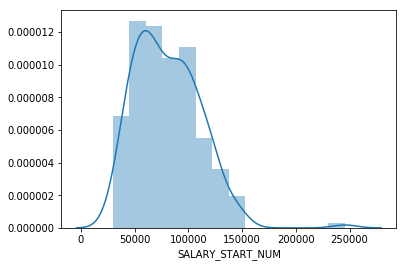

In [107]:
sns.distplot(data_df.SALARY_START_NUM[data_df.SALARY_START_NUM.notnull()])

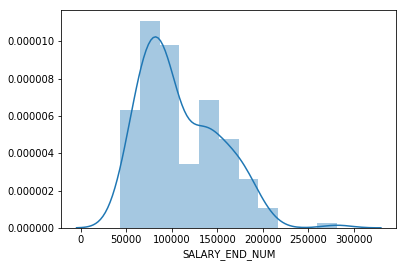

In [19]:
sns.distplot(data_df.SALARY_END_NUM[data_df.SALARY_END_NUM.notnull()])

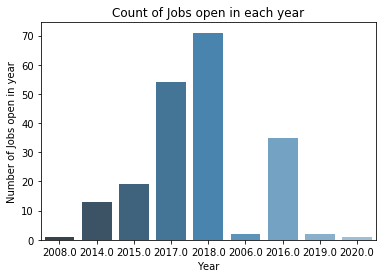

In [123]:
fig, ax = plt.subplots()
g = sns.countplot(x = "OPEN_YEAR", data = data_df, palette="Blues_d")
ax.set(xlabel='Year', ylabel='Number of Jobs open in year', title='Count of Jobs open in each year')
plt.close(2)

fig, ax = plt.subplots(figsize=(10, 10))
g = sns.catplot(x = "OPEN_YEAR", y = "SALARY_START_NUM", data = data_df, kind = "box", ax= ax, palette="Blues_d")
ax.set(xlabel='Job Open Year', ylabel='Salary Start', title='Distribution of Salary Start over years')
g.set_xticklabels(rotation = 30)
plt.close(2)

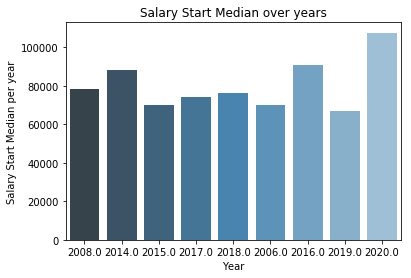

In [120]:
fig, ax = plt.subplots()
g = sns.barplot(x='OPEN_YEAR', y='SALARY_START_NUM', data=data_df, estimator=np.median, ci = None, palette="Blues_d")
ax.set(xlabel='Year', ylabel='Salary Start Median per year', title='Salary Start Median over years')
plt.close(2)

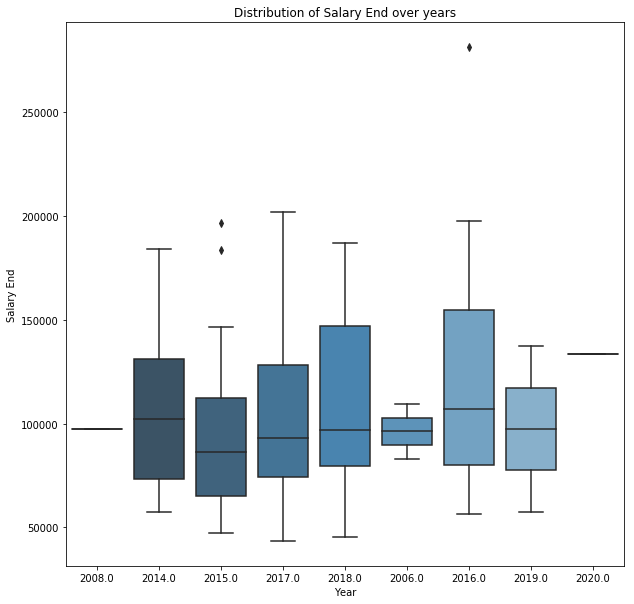

In [121]:
fig, ax = plt.subplots(figsize=(10, 10))
g = sns.catplot(x = "OPEN_YEAR", y = "SALARY_END_NUM", data = data_df, kind = "box", ax= ax, palette="Blues_d")
ax.set(xlabel='Year', ylabel='Salary End', title='Distribution of Salary End over years')
g.set_xticklabels(rotation = 30)
plt.close(2)

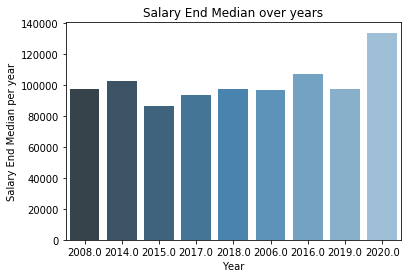

In [122]:
fig, ax = plt.subplots()
g = sns.barplot(x='OPEN_YEAR', y='SALARY_END_NUM', data=data_df, estimator=np.median, ci = None, palette="Blues_d")
ax.set(xlabel='Year', ylabel='Salary End Median per year', title='Salary End Median over years')
plt.close(2)

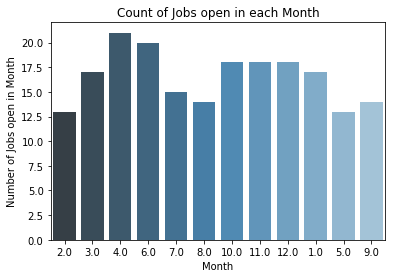

In [124]:
fig, ax = plt.subplots()
g = sns.countplot(x = "OPEN_MONTH", data = data_df, palette="Blues_d")
ax.set(xlabel='Month', ylabel='Number of Jobs open in Month', title='Count of Jobs open in each Month')
plt.close(2)


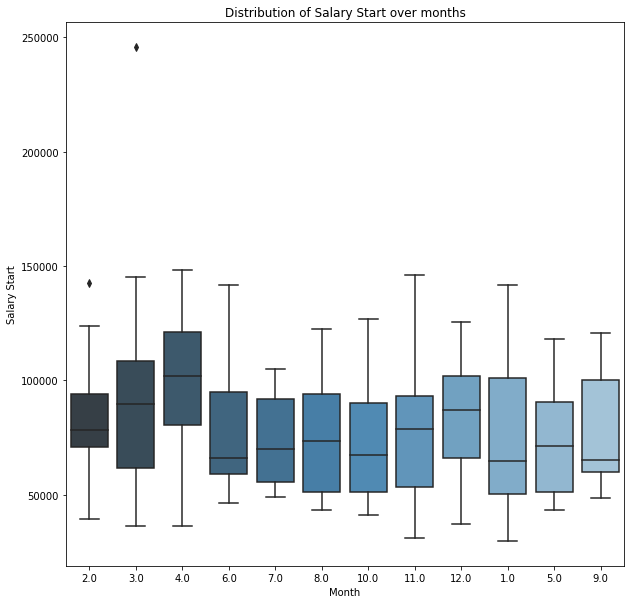

In [125]:
fig, ax = plt.subplots(figsize=(10, 10))
g = sns.catplot(x = "OPEN_MONTH", y = "SALARY_START_NUM", data = data_df, kind = "box", ax= ax, palette="Blues_d")
ax.set(xlabel='Month', ylabel='Salary Start', title='Distribution of Salary Start over months')
g.set_xticklabels(rotation = 30)
plt.close(2)

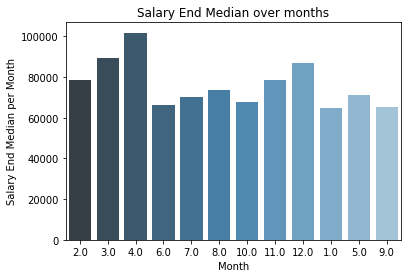

In [138]:
fig, ax = plt.subplots()
g = sns.barplot(x='OPEN_MONTH', y='SALARY_START_NUM', data=data_df, estimator=np.median, ci = None, palette="Blues_d")
ax.set(xlabel='Month', ylabel='Salary End Median per Month', title='Salary End Median over months')
plt.close(2)

In [111]:
exp = []
for elm in data_df.EXPERIENCE_LENGTH:
    if type(elm) == str:
        if elm.lower().strip().startswith('one'):
            exp.append('1')
        elif elm.lower().strip().startswith('two'):
            exp.append('2')
        elif elm.lower().strip().startswith('three'):
            exp.append('3')
        elif elm.lower().strip().startswith('four'):
            exp.append('4')
        elif elm.lower().strip().startswith('five'):
            exp.append('5')
        elif elm.lower().strip().startswith('six year'):
            exp.append('6')
        elif elm.lower().strip().startswith('six mon'):
            exp.append('0.5')
        else:
            exp.append('oth')
            
    else:
        exp.append('0')
        
data_df['EXP_NUM'] = exp

In [27]:
data_df.EXPERIENCE_LENGTH.unique()

array(['One year', nan, 'Two years', 'Six months', 'Six years',
       'Four years', 'two years', 'six months', 'three years',
       'Three years', 'one year', 'Five years', 'four years'],
      dtype=object)

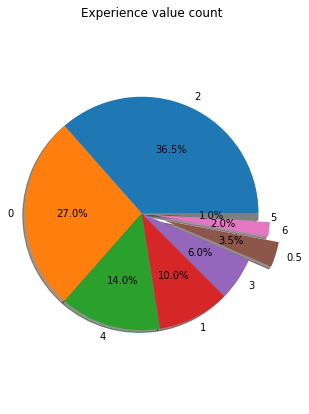

In [112]:
experience=data_df['EXP_NUM'].value_counts().reset_index()
labels=experience['index']
sizes=experience['EXP_NUM']
plt.figure(figsize=(5,7))
plt.pie(sizes,explode=(0, 0, 0, 0,0,0.2,0.1,0),labels=labels, autopct='%1.1f%%', shadow = True)
plt.gca().axis('equal')
plt.title('Experience value count')
plt.show()

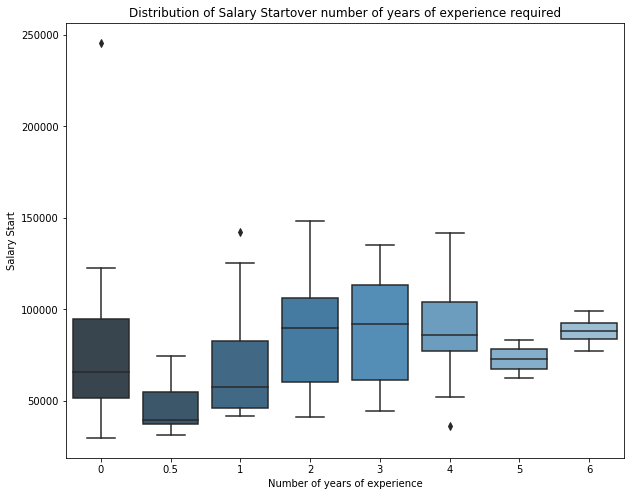

In [133]:
fig, ax = plt.subplots(figsize=(10, 8))
g = sns.catplot(x = "EXP_NUM", y = "SALARY_START_NUM", data = data_df, kind = "box", ax= ax, palette="Blues_d")
ax.set(xlabel='Number of years of experience', ylabel='Salary Start', title='Distribution of Salary Start\
 over number of years of experience required')
g.set_xticklabels(rotation = 30)
plt.close(2)

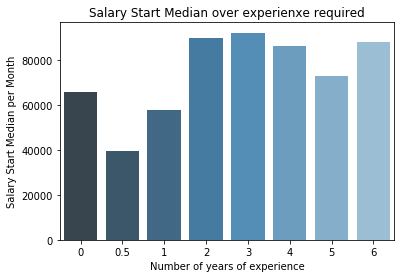

In [134]:
fig, ax = plt.subplots()
g = sns.barplot(x='EXP_NUM', y='SALARY_START_NUM', data=data_df, estimator=np.median, ci = None, palette="Blues_d")
ax.set(xlabel='Number of years of experience', ylabel='Salary Start Median per Month', title='Salary Start Median over \
experienxe required')
plt.close(2)

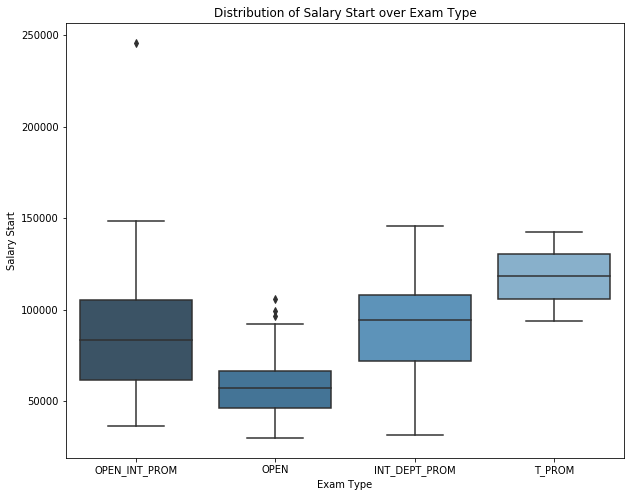

In [135]:
fig, ax = plt.subplots(figsize=(10, 8))
g = sns.catplot(x = "EXAM_TYPE", y = "SALARY_START_NUM", data = data_df, kind = "box", ax= ax, palette="Blues_d")
ax.set(xlabel='Exam Type', ylabel='Salary Start', title='Distribution of Salary Start over Exam Type')
g.set_xticklabels(rotation = 30)
plt.close(2)

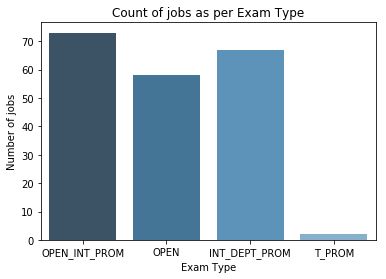

In [136]:
fig, ax = plt.subplots()
g = sns.countplot(x = "EXAM_TYPE", data = data_df, palette="Blues_d")
ax.set(xlabel='Exam Type', ylabel='Number of jobs', title='Count of jobs as per Exam Type')
plt.close(2)

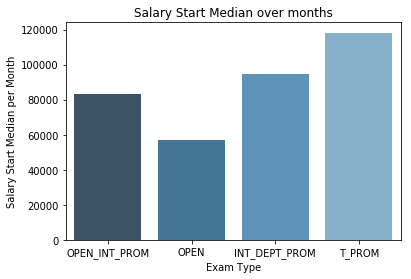

In [137]:
fig, ax = plt.subplots()
g = sns.barplot(x='EXAM_TYPE', y='SALARY_START_NUM', data=data_df, estimator=np.median, ci = None, palette="Blues_d")
ax.set(xlabel='Exam Type', ylabel='Salary Start Median per Month', title='Salary Start Median over months')
plt.close(2)

In [28]:
req_all = ' '.join(req for req in data_df.REQUIREMENTS)

In [31]:
stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()
lem_req = []
for word in word_tokenize(req_all):
    if word not in stop_words:
        lem_req.append(lem.lemmatize(word))
        
vect = TfidfVectorizer(ngram_range=(1,3), max_features=100)
tfidf_score = vect.fit_transform(lem_req)

In [32]:
vect.vocabulary_.keys()

dict_keys(['one', 'year', 'full', 'time', 'full time', 'paid', 'experience', 'senior', 'management', 'city', 'los', 'angeles', 'class', 'least', 'level', 'provides', 'professional', 'work', 'call', 'degree', 'recognized', 'college', 'university', 'four', 'two', 'must', 'supervising', 'graduation', 'accredited', 'four year', 'semester', 'quarter', 'unit', 'successful', 'completion', 'trade', 'school', 'may', 'six', 'month', 'required', 'control', 'system', 'personnel', 'administration', 'requirement', 'state', 'and', 'or', 'and or', 'supervisor', 'california', 'training', 'current', 'license', 'valid', 'related', 'equipment', '12', 'installation', 'maintenance', 'repair', 'following', 'building', 'airport', 'information', 'planning', 'engineering', 'mechanical', 'electrical', 'communication', 'design', 'construction', 'program', 'engineer', 'position', 'service', 'high', 'public', 'worker', 'operation', 'commercial', 'police', 'certificate', 'three', 'officer', 'department', 'course', '

In [34]:
with open('CityofLA/Job Bulletins/311 DIRECTOR  9206 041814.txt', encoding = 'utf-8') as f:
    p = f.read()
    print(p)

311 DIRECTOR
Class Code:       9206
Open Date:  04-18-14
ANNUAL SALARY 

$125,175 to $155,514 

DUTIES

A 311 Director is responsible for the successful operation and expansion of the 311 Call Center in the Information Technology Agency (ITA) which answers call from constituents regarding Citywide services provided by City departments; works to ensure the efficient and effective resolution of any issues that may arise; plans, directs, hires, coaches, and coordinates a large staff of professional, technical and clerical employees engaged in the implementation, administration, and operations of the City's 311 Call Center; applies sound supervisor principles and techniques in building and maintaining and effective work force; fulfills equal opportunity responsibilities; and does related work.

REQUIREMENTS

1. One year of full-time paid experience as a Senior Management Analyst with the City of Los Angeles or in a class which is at least at the level which provides professional experience

In [40]:
summ = gensim.summarization.summarize(p, ratio = 0.1)

In [41]:
print(summ)

A 311 Director is responsible for the successful operation and expansion of the 311 Call Center in the Information Technology Agency (ITA) which answers call from constituents regarding Citywide services provided by City departments; works to ensure the efficient and effective resolution of any issues that may arise; plans, directs, hires, coaches, and coordinates a large staff of professional, technical and clerical employees engaged in the implementation, administration, and operations of the City's 311 Call Center; applies sound supervisor principles and techniques in building and maintaining and effective work force; fulfills equal opportunity responsibilities; and does related work.
1. One year of full-time paid experience as a Senior Management Analyst with the City of Los Angeles or in a class which is at least at the level which provides professional experience in supervisory or managerial work relating to a call center with at least 50 call agents or a call center that receive

In [52]:
sent = nltk.sent_tokenize(p)
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(sent)

km = KMeans(n_clusters = 10,init='k-means++', max_iter=100, n_init=1)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [57]:
avg = []
closest = []
for j in range(10):
    idx = np.where(km.labels_ == j)[0]
    avg.append(np.mean(idx))
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, X)
ordering = sorted(range(10), key=lambda k: avg[k])
summary = ' '.join([sent[closest[idx]] for idx in ordering])

In [58]:
summary

'Eight years of full-time paid experience in a call center environment with at least 50 call agents or call center that receives at least one million calls annually, two years of which must be supervising staff working at such a call center. In addition to the regular City application, all applicants must complete a 311 Director Qualifications Questionnaire at the time of filing. WHERE TO APPLY\n\nApplications will only be accepted online. You must have received a regular appointment to a City position or be on a reserve list to apply for this examination as a promotional candidate; 2) Applicants currently employed by the City of Los Angeles on a part-time or exempt basis who meet the minimum requirements; 3) Remaining applicants who meet the minimum requirements in sufficient numbers to meet hiring needs in the order that applications were received. NOTES:\n\n1. Appointment to this position is subject to a one-year probationary period as provided by Section 1011 of the Los Angeles Cit